In [ ]:
1-2.2 Observe gradient norm during training.


Total number of parameters: 573
Epoch: 100, Loss: 0.0727, Grad-Norm: 0.1756
Epoch: 200, Loss: 0.0616, Grad-Norm: 0.1338
Epoch: 300, Loss: 0.0524, Grad-Norm: 0.1286
Epoch: 400, Loss: 0.0450, Grad-Norm: 0.1289
Epoch: 500, Loss: 0.0396, Grad-Norm: 0.1211
Epoch: 600, Loss: 0.0352, Grad-Norm: 0.1238
Epoch: 700, Loss: 0.0313, Grad-Norm: 0.1170
Epoch: 800, Loss: 0.0278, Grad-Norm: 0.1080
Epoch: 900, Loss: 0.0245, Grad-Norm: 0.1033
Epoch: 1000, Loss: 0.0217, Grad-Norm: 0.0984


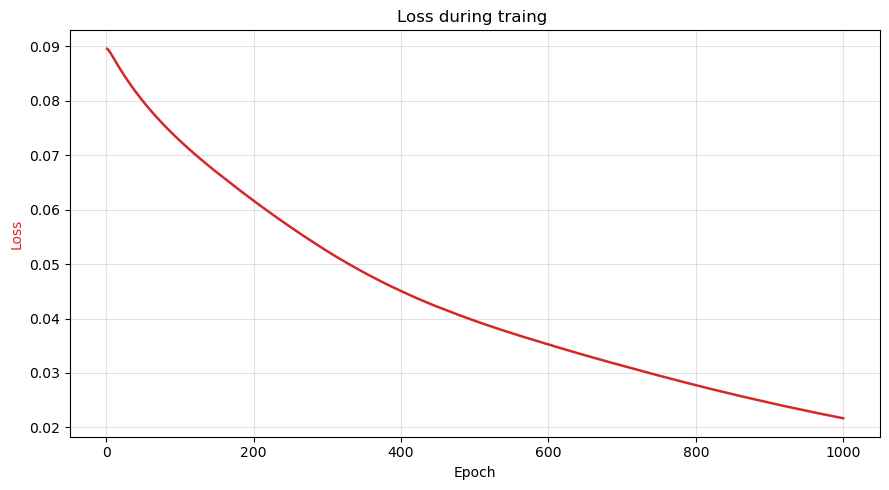

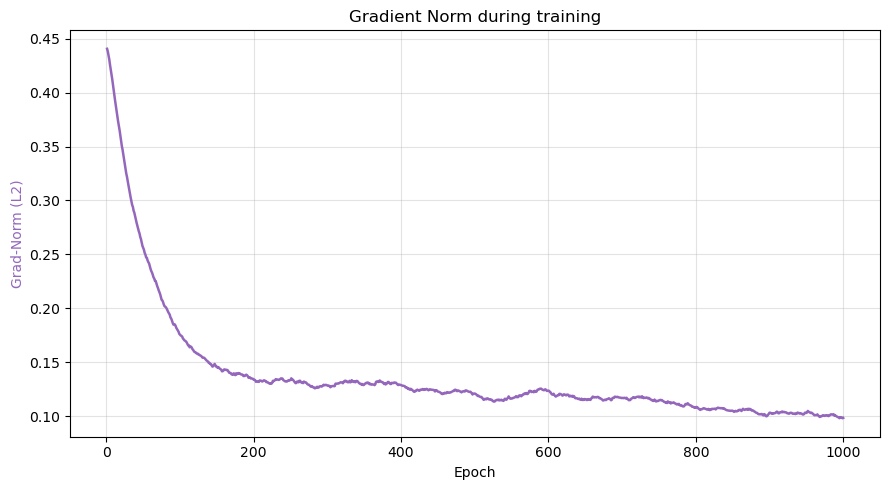

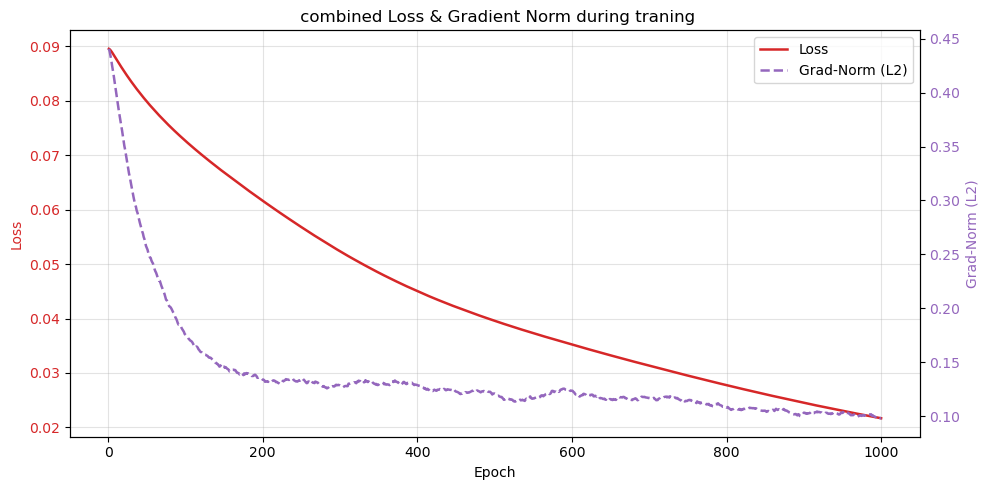

Saved:
  results/loss_only.png
  results/grad_only.png
  results/loss_grad_combined.png


In [1]:
\

import os, math, random, numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


SEED = 1337
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OUTDIR = "results"
os.makedirs(OUTDIR, exist_ok=True)

EPOCHS       = 1000
PRINT_EVERY  = 100     # print and heartbeat
LR           = 1e-2
WEIGHT_DECAY = 0.0
N_TRAIN      = 256
BATCH_SIZE   = 64
EMA          = 0.98    # stronger smoothing for clean curves (set 0.0 to disable)


COLOR_LOSS = "#d62728"   
COLOR_GRAD = "#9467bd"   


random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def f_true(x):
    # smooth but nontrivial target
    return np.sin(2.2 * x) * np.sinc(0.7 * x) + 0.1 * x

x = np.linspace(-3, 3, N_TRAIN).astype(np.float32)
y = f_true(x).astype(np.float32)
X = torch.from_numpy(x).view(-1, 1).to(DEVICE)
Y = torch.from_numpy(y).view(-1, 1).to(DEVICE)

def batches(n, bs):
    idx = np.arange(n)
    np.random.shuffle(idx)
    for s in range(0, n, bs):
        yield idx[s:s+bs]


class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 22)
        self.fc2 = nn.Linear(22, 22)
        self.fc3 = nn.Linear(22, 1)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

@torch.no_grad()
def grad_norm_l2(model):
    g = [p.grad.view(-1) for p in model.parameters() if p.grad is not None]
    if not g: return 0.0
    return float(torch.linalg.vector_norm(torch.cat(g), ord=2).cpu())


model = TinyMLP().to(DEVICE)
opt = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

print("Total number of parameters:", count_params(model))

loss_epoch, grad_epoch = [], []
ema_loss, ema_grad = None, None
N = X.shape[0]

for ep in range(1, EPOCHS + 1):
    model.train()
    sum_loss, sum_grad, batches_seen = 0.0, 0.0, 0

    for bi in batches(N, BATCH_SIZE):
        xb, yb = X[bi], Y[bi]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        gnorm = grad_norm_l2(model)
        opt.step()

        sum_loss += float(loss.detach().cpu())
        sum_grad += gnorm
        batches_seen += 1

    # per-epoch means remove batch noise
    mean_loss = sum_loss / max(1, batches_seen)
    mean_grad = sum_grad / max(1, batches_seen)

    # EMA smoothing for clean curves
    if EMA > 0.0:
        if ema_loss is None:
            ema_loss, ema_grad = mean_loss, mean_grad
        else:
            ema_loss = EMA * ema_loss + (1 - EMA) * mean_loss
            ema_grad = EMA * ema_grad + (1 - EMA) * mean_grad
        rec_loss, rec_grad = ema_loss, ema_grad
    else:
        rec_loss, rec_grad = mean_loss, mean_grad

    loss_epoch.append(rec_loss)
    grad_epoch.append(rec_grad)

   
    if ep % PRINT_EVERY == 0:
        print(f"Epoch: {ep}, Loss: {rec_loss:.4f}, Grad-Norm: {rec_grad:.4f}")


epochs = np.arange(1, EPOCHS + 1)
loss_arr = np.array(loss_epoch)
grad_arr = np.array(grad_epoch)


fig1, ax1 = plt.subplots(figsize=(9, 5))
ax1.plot(epochs, loss_arr, linewidth=1.8, color=COLOR_LOSS)
ax1.set_title("Loss during traing ")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=COLOR_LOSS)
ax1.grid(True, alpha=0.35)
fig1.tight_layout()
p1 = os.path.join(OUTDIR, "loss_only.png")
plt.savefig(p1, dpi=180); plt.show()


fig2, ax2 = plt.subplots(figsize=(9, 5))
ax2.plot(epochs, grad_arr, linewidth=1.8, color=COLOR_GRAD)
ax2.set_title("Gradient Norm during training")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Grad-Norm (L2)", color=COLOR_GRAD)
ax2.grid(True, alpha=0.35)
fig2.tight_layout()
p2 = os.path.join(OUTDIR, "grad_only.png")
plt.savefig(p2, dpi=180); plt.show()


fig3, axL = plt.subplots(figsize=(10, 5))
line_loss, = axL.plot(epochs, loss_arr, linewidth=1.8, color=COLOR_LOSS, label="Loss")
axL.set_xlabel("Epoch")
axL.set_ylabel("Loss", color=COLOR_LOSS)
axL.tick_params(axis='y', labelcolor=COLOR_LOSS)
axL.grid(True, alpha=0.35)

axR = axL.twinx()
line_grad, = axR.plot(epochs, grad_arr, linewidth=1.8, color=COLOR_GRAD, linestyle="--", label="Grad-Norm (L2)")
axR.set_ylabel("Grad-Norm (L2)", color=COLOR_GRAD)
axR.tick_params(axis='y', labelcolor=COLOR_GRAD)

axL.legend([line_loss, line_grad], ["Loss", "Grad-Norm (L2)"], loc="upper right")
plt.title(" combined Loss & Gradient Norm during traning")
fig3.tight_layout()
p3 = os.path.join(OUTDIR, "loss_grad_combined.png")
plt.savefig(p3, dpi=180); plt.show()

print(f"Saved:\n  {p1}\n  {p2}\n  {p3}")
